
![alt text](https://pbs.twimg.com/media/DilKBjUVsAA74j1.jpg)

## Background Data

- Where there is salt, there is oil.
- But where is the salt?
- Classifying seismic imaging currently requires human (salt/not salt)
- Can we use an algorithm to do this instead? (yes)
- Seismic data is like an ultra-sound of the subsurface
- It uses wavelengths around 1m to 100m
- The Society of Exploration Geophysicists has 10K publications using the keyword 'salt'
- We can think of Earth as layered.
- Sand gets deposited on top of existing sand. And in comes the salt.
- There is an entire research branch dedicated to salt tectonics, that is the movement of salt in the subsurface.

## Our steps

- Install Dependencies
- Upload our Dataset
- View the labeled seismic imaging data
- Plot the depth distribution in the training data 
- Plot the proportion of salt vs depth in the training data
- Build a U-Net algorithm to learn the mapping between seismic images and the salt filter mask


In [1]:
#read/write image data
#!pip install imageio
#deep learning library
#!pip install torch
#access kaggle datasets from colab
#!pip install kaggle
#model loading
#!pip install ipywidgets

In [2]:
#File input output
import os
#matrix math
import numpy as np
#read/write image data
import imageio
#visualize data
import matplotlib.pyplot as plt
#data preprocessing 
import pandas as pd
#deep learning
import torch
#just in case we need a backup datasets
from torch.utils import data
#will output the plot right below the cell that produces it
%matplotlib inline

In [3]:
#allows us to upload files into colab
#we'll need to upload the kaggle.json file
#in kaggle, under accounts, click 'create new API token'
#upload the kaggle.json file that is automatically downloaded
#from google.colab import files
#files.upload()

In [4]:
#ensure its there
#!ls -lha kaggle.json

In [5]:
# The Kaggle API client expects this file to be in ~/.kaggle,
# so lets move it there.
#!mkdir -p ~/.kaggle
#!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
#!chmod 600 ~/.kaggle/kaggle.json

In [6]:
#lets now download our dataset
#!kaggle competitions download -c tgs-salt-identification-challenge 

In [7]:
#and we'll need those training images unzipped
#!ls
#!unzip train.zip

In [8]:
#lets create a class to represent this data, to make it easier to access

class TGSSaltDataset(data.Dataset):
    #init with the location of the dataset, and the list of file 
    def __init__(self, root_path, file_list):
        self.root_path = root_path
        self.file_list = file_list
    #get method - how long is the list
    def __len__(self):
        return len(self.file_list)
    #get method - return the seismic image + label for a given index
    def __getitem__(self, index):
        #if the index is out of bounds, get a random image
        if index not in range(0, len(self.file_list)):
            return self.__getitem__(np.random.randint(0, self.__len__()))
        #define a file ID using the index parameter
        file_id = self.file_list[index]
        #image folder + path
        image_folder = os.path.join(self.root_path, "images")
        image_path = os.path.join(image_folder, file_id + ".png")
        #label folder + path
        mask_folder = os.path.join(self.root_path, "masks")
        mask_path = os.path.join(mask_folder, file_id + ".png")
        #read it, store it in memory as a byte array
        image = np.array(imageio.imread(image_path), dtype=np.uint8)
        mask = np.array(imageio.imread(mask_path), dtype=np.uint8)
        #return image + label
        return image, mask

In [9]:
#train image + mask data
train_mask = pd.read_csv('train.csv')
#depth data
depth = pd.read_csv('depths.csv')
#training path
train_path = "./data/train/"

#list of files
file_list = list(train_mask['id'].values)
#define our dataset using our class
dataset = TGSSaltDataset(train_path, file_list)

In [10]:
#function to visualize these images
def plot2x2Array(image, mask):
    #invoke matplotlib!
    f, axarr = plt.subplots(1,2)
    axarr[0].imshow(image)
    axarr[1].imshow(mask)
    axarr[0].grid()
    axarr[1].grid()
    axarr[0].set_title('Image')
    axarr[1].set_title('Mask')

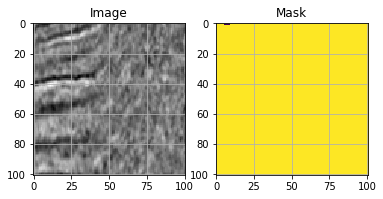

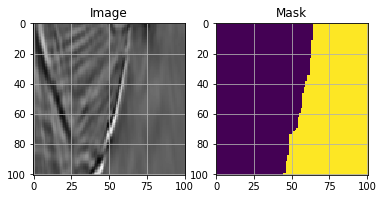

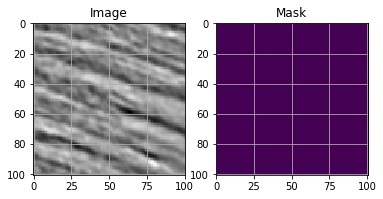

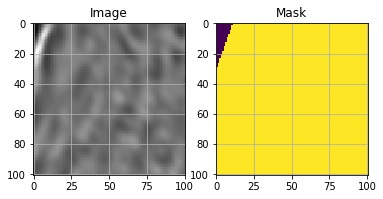

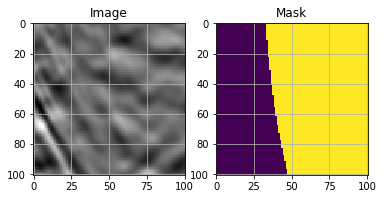

In [11]:
for i in range(5):
    image, mask = dataset[np.random.randint(0, len(dataset))]
    plot2x2Array(image, mask)

Text(0.5,1,'Depth distribution')

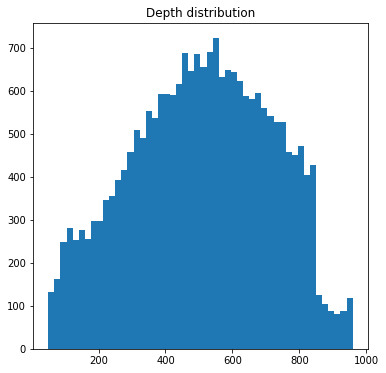

In [12]:
plt.figure(figsize = (6, 6))
plt.hist(depth['z'], bins = 50)
plt.title('Depth distribution')

Run-length encoding (RLE) is a very simple form of lossless data compression in which runs of data (that is, sequences in which the same data value occurs in many consecutive data elements) are stored as a single data value and count, rather than as the original run. 

![alt text](https://sites.google.com/a/ruknuddin.com/inqilab-patel-magazine/_/rsrc/1525765922681/term-of-the-day/runlengthencoding/RunLengthEncoding.PNG)



In [13]:
#convert to image
def rleToMask(rleString,height,width):
    #width heigh
    rows,cols = height,width
    try:
        #get numbers
        rleNumbers = [int(numstring) for numstring in rleString.split(' ')]
        #get pairs
        rlePairs = np.array(rleNumbers).reshape(-1,2)
        #create an image
        img = np.zeros(rows*cols,dtype=np.uint8)
        #for each pair
        for index,length in rlePairs:
            #get the pixel value 
            index -= 1
            img[index:index+length] = 255
        
        
        #reshape
        img = img.reshape(cols,rows)
        img = img.T
    
    #else return empty image
    except:
        img = np.zeros((cols,rows))
    
    return img

In [14]:
#for measuring how salty an image is
def salt_proportion(imgArray):
    try: 
        unique, counts = np.unique(imgArray, return_counts=True)
        ## The total number of pixels is 101*101 = 10,201
        return counts[1]/10201.
    
    except: 
        return 0.0

In [15]:
train_mask['mask'] = train_mask['rle_mask'].apply(lambda x: rleToMask(x, 101,101))
train_mask['salt_proportion'] = train_mask['mask'].apply(lambda x: salt_proportion(x))

In [16]:
merged = train_mask.merge(depth, how = 'left')
merged.head()

,id,rle_mask,mask,salt_proportion,z
0,575d24d81d,NaN,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.000000,843
1,a266a2a9df,5051 5151,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0.504950,794
2,75efad62c1,9 93 109 94 210 94 310 95 411 95 511 96 612 96...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0.993334,468
3,34e51dba6a,48 54 149 54 251 53 353 52 455 51 557 50 659 4...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0.149201,727
4,4875705fb0,1111 1 1212 1 1313 1 1414 1 1514 2 1615 2 1716...,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0.042839,797


Text(0.5,1,'Proportion of salt v. depth')

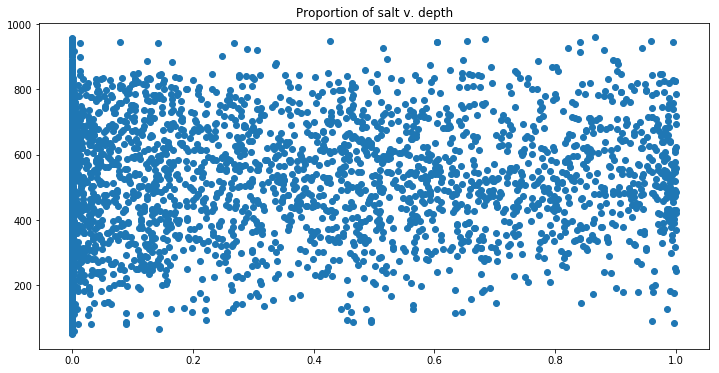

In [17]:
plt.figure(figsize = (12, 6))
plt.scatter(merged['salt_proportion'], merged['z'])
plt.title('Proportion of salt v. depth')

In [18]:
print("Correlation: ", np.corrcoef(merged['salt_proportion'], merged['z'])[0, 1])


Correlation:  0.1036158036555743


#### U-Nets

- This looks like a computer vision problem!
- What outperforms everything else when it comes to computer vision most of the time? (hint deep learning)
- Specifically, deep convolutional neural networks.
- AlexNet
- VGG-16, VGG-19;
- Inception Nets;
- ResNet;
- Squeeze Net 

![alt text](https://pics.spark-in.me/upload/388373c74ab710cc4c429538d4779a93.png)
![alt text](https://pics.spark-in.me/upload/8b468c6dd60a499e6cdde0af803cb96f.png)

#### Why not use one of these, why use a U-Net?

- U-NET is considered one of standard architectures for image classification tasks, when we need not only to segment the whole image by its class, but also to segment areas of image by class, i.e. produce a mask that will separate image into several classes.
-its architecture is input image size agnostic since it does not contain fully connected layers 
- Because of many layers takes significant amount of time to train;
- U-Net is designed like an auto-encoder. 
- It has an encoding path (“contracting”) paired with a decoding path (“expanding”) which gives it the “U” shape.  
- However, in contrast to the autoencoder, U-Net predicts a pixelwise segmentation map of the input image rather than classifying the input image as a whole. 
- For each pixel in the original image, it asks the question: “To which class does this pixel belong?
- This flexibility allows U-Net to predict different parts of the seismic image (salt, not salt) simultaneously.
- U-Net passes the feature maps from each level of the contracting path over to the analogous level in the expanding path.  
- These are similar to residual connections in a ResNet type model, and allow the classifier to consider features at various scales and complexities to make its decision.

#### What does a U-Net look like?

![alt text](https://cdn-images-1.medium.com/max/800/1*dKPBgCdJx6zj3MpED3lcNA.png)
![alt text](https://pics.spark-in.me/upload/cb8197bb7e57317eda88f921dfc1c413.png)

its high to low res, then low res to high res

- The first part (encoder) is where we apply convolutional blocks followed by a maxpool downsampling to encode the input image into feature representations at multiple different levels.

convolutions→ downsampling.

Example

```
# a sample down block
def make_conv_bn_relu(in_channels, out_channels, kernel_size=3, stride=1, padding=1):
    return [
        nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size,  stride=stride, padding=padding, bias=False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    ]
self.down1 = nn.Sequential(
    *make_conv_bn_relu(in_channels, 64, kernel_size=3, stride=1, padding=1 ),
    *make_conv_bn_relu(64, 64, kernel_size=3, stride=1, padding=1 ),
)

# convolutions followed by a maxpool
down1 = self.down1(x)
out1   = F.max_pool2d(down1, kernel_size=2, stride=2)

```

- The  second part (decoder) of the network consists of upsample and concatenation followed by regular convolution operations

upsampling → concatenation →convolutions.

```
# a sample up block
def make_conv_bn_relu(in_channels, out_channels, kernel_size=3, stride=1, padding=1):
    return [
        nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size,  stride=stride, padding=padding, bias=False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True)
    ]
self.up4 = nn.Sequential(
    *make_conv_bn_relu(128,64, kernel_size=3, stride=1, padding=1 ),
    *make_conv_bn_relu(64,64, kernel_size=3, stride=1, padding=1 )
)
self.final_conv = nn.Conv2d(32, num_classes, kernel_size=1, stride=1, padding=0 )

# upsample out_last, concatenate with down1 and apply conv operations
out   = F.upsample(out_last, scale_factor=2, mode='bilinear')  
out   = torch.cat([down1, out], 1)
out   = self.up4(out)

# final 1x1 conv for predictions
final_out = self.final_conv(out)
```




In [19]:
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras import backend as K

Using TensorFlow backend.


In [20]:
im_width = 128
im_height = 128
border = 5
im_chan = 2 # Number of channels: first is original and second cumsum(axis=0)
n_features = 1 # Number of extra features, like depth
#path_train = '../input/train/'
#path_test = '../input/test/'

In [21]:
# Build U-Net model
input_img = Input((im_height, im_width, im_chan), name='img')
input_features = Input((n_features, ), name='feat')

c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (input_img)
c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (p1)
c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (p2)
c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (p3)
c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

# Join features information in the depthest layer
f_repeat = RepeatVector(8*8)(input_features)
f_conv = Reshape((8, 8, n_features))(f_repeat)
p4_feat = concatenate([p4, f_conv], -1)

c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (p4_feat)
c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (c5)

u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c5)
#check out this skip connection thooooo
u6 = concatenate([u6, c4])
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (u6)
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (c6)

u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (u7)
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (c7)

u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (u8)
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (c8)

u9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (u9)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[input_img, input_features], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy') #, metrics=[mean_iou]) # The mean_iou metrics seens to leak train and test values...
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                (None, 128, 128, 2)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 8)  152         img[0][0]                        
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 128, 128, 8)  584         conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 64, 64, 8)    0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (

In [22]:
#!pip install ipywidgets


In [23]:
import sys
from tqdm import tqdm
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from skimage.transform import resize


train_ids = next(os.walk(train_path+"images"))[2]


# Get and resize train images and masks
X = np.zeros((len(train_ids), im_height, im_width, im_chan), dtype=np.float32)
y = np.zeros((len(train_ids), im_height, im_width, 1), dtype=np.float32)
X_feat = np.zeros((len(train_ids), n_features), dtype=np.float32)
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = train_path
    
    # Depth
    #X_feat[n] = depth.loc[id_.replace('.png', ''), 'z']
    
    # Load X
    img = load_img(path + '/images/' + id_, grayscale=True)
    x_img = img_to_array(img)
    x_img = resize(x_img, (128, 128, 1), mode='constant', preserve_range=True)
    
    # Create cumsum x
    x_center_mean = x_img[border:-border, border:-border].mean()
    x_csum = (np.float32(x_img)-x_center_mean).cumsum(axis=0)
    x_csum -= x_csum[border:-border, border:-border].mean()
    x_csum /= max(1e-3, x_csum[border:-border, border:-border].std())

    # Load Y
    mask = img_to_array(load_img(path + '/masks/' + id_, grayscale=True))
    mask = resize(mask, (128, 128, 1), mode='constant', preserve_range=True)

    # Save images
    X[n, ..., 0] = x_img.squeeze() / 255
    X[n, ..., 1] = x_csum.squeeze()
    y[n] = mask / 255

print('Done!')

Getting and resizing train images and masks ... 


  0%|          | 0/4000 [00:00<?, ?it/s]C:\Users\SCatheline\AppData\Local\Continuum\anaconda3\envs\tensorflow-GPU\lib\site-packages\keras_preprocessing\image.py:489: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '
C:\Users\SCatheline\AppData\Local\Continuum\anaconda3\envs\tensorflow-GPU\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
100%|██████████| 4000/4000 [00:13<00:00, 287.02it/s]


Done!


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_valid, X_feat_train, X_feat_valid, y_train, y_valid = train_test_split(X, X_feat, y, test_size=0.15, random_state=42)

In [ ]:
callbacks = [
    EarlyStopping(patience=5, verbose=1),
    ReduceLROnPlateau(patience=3, verbose=1),
    ModelCheckpoint('model-tgs-salt-1.h5', verbose=2, save_best_only=True, save_weights_only=True)
]

results = model.fit({'img': X_train, 'feat': X_feat_train}, y_train, batch_size=16, epochs=10,verbose=0, callbacks=callbacks,
                    validation_data=({'img': X_valid, 'feat': X_feat_valid}, y_valid))